# Fine-tuning EfficientNet for identifying pneumonia in chest scans

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import random
from PIL import Image
import torchvision.transforms as transforms

In [2]:
%load_ext autoreload
%autoreload 2

### GPUs will be necessary to train in a reasonable time

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# %cd /content/drive/MyDrive/ML_2025/MLCourse_2025/Tutorial6_transfer_learning/

### Download the Chest X-Ray Images (Pneumonia) dataset

5,863 X-Ray images of chests of healthy patients and patients with pneumonia

- https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
- http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

 ![ lungs.png ](lungs.png)

In [ ]:
# ! curl -L -o chest-xray-pneumonia.zip https://www.kaggle.com/api/v1/datasets/download/paultimothymooney/chest-xray-pneumonia

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2349M  100 2349M    0     0  36.1M      0  0:01:04  0:01:04 --:--:-- 36.6M


In [ ]:
# ! unzip -o chest-xray-pneumonia.zip

Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray/__MACOSX/._chest_xray  
  inflating: chest_xray/__MACOSX/chest_xray/._.DS_Store  
  inflating: chest_xray/__MACOSX/chest_xray/._test  
  inflating: chest_xray/__MACOSX/chest_xray/._train  
  inflating: chest_xray/__MACOSX/chest_xray/test/._.DS_Store  
  inflating: chest_xray/__MACOSX/chest_xray/test/._NORMAL  
  inflating: chest_xray/__MACOSX/chest_xray/test/._PNEUMONIA  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0001-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0003-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0005-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0006-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0007-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0009-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0010-0001.jpeg  
  inflating: chest_x

In [3]:
images_normal_train = glob.glob('chest_xray/train/NORMAL/*.jpeg')
images_pneumo_train = glob.glob('chest_xray/train/PNEUMONIA/*.jpeg')
images_normal_valid = glob.glob('chest_xray/val/NORMAL/*.jpeg')
images_pneumo_valid = glob.glob('chest_xray/val/PNEUMONIA/*.jpeg')
images_normal_test  = glob.glob('chest_xray/test/NORMAL/*.jpeg')
images_pneumo_test  = glob.glob('chest_xray/test/PNEUMONIA/*.jpeg')

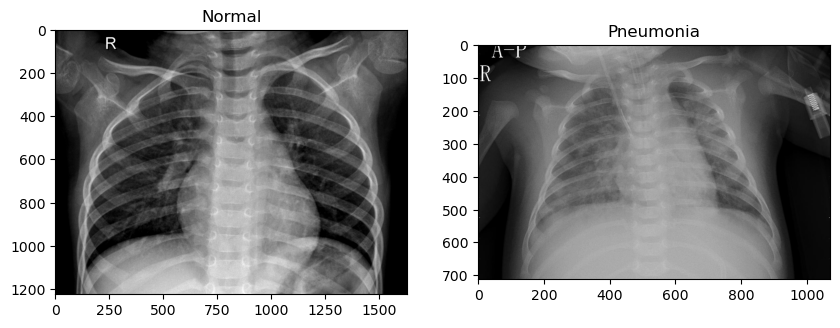

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
normal_idx = random.randint(0, len(images_normal_valid)-1)
pneumo_idx = random.randint(0, len(images_normal_valid)-1)
axes[0].imshow(plt.imread(images_normal_valid[normal_idx]), cmap='gray')
axes[0].set_title('Normal')
axes[1].imshow(plt.imread(images_pneumo_valid[pneumo_idx]), cmap='gray')
axes[1].set_title('Pneumonia')
plt.show()

### Create torch Dataset

In [5]:
class ChestData(Dataset):

    def __init__(self, images_normal, images_pneumo):

        self.images = images_normal + images_pneumo
        self.labels = [0]*len(images_normal) + [1]*len(images_pneumo)

        ### The usual transforms (img -> tensor -> resize -> normalize)
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((256,256)),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                  std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):

        return len(self.labels)
    
    def  __getitem__(self, idx):

        img = Image.open(self.images[idx]).convert('RGB')
        lbl = self.labels[idx]

        img_tensor = self.transform(img)
        return img_tensor, lbl

In [6]:
bs = 128
train_dl = DataLoader(ChestData(images_normal_train, images_pneumo_train), batch_size=bs, shuffle=True)
valid_dl = DataLoader(ChestData(images_normal_valid, images_pneumo_valid), batch_size=bs, shuffle=False)

### Define our pretrained model + custom fine-tuning linear layer

- we start from EfficientNet_B6 and load the pre-trained weights
- then we replace the final classifier layer with our own
- we retrain our transfer-learning model on the new dataset. 
  - Note that _only_ the classifier layer is being retrained.
  - It relies on the feature extraction of the pretrained model

In [ ]:
### Following https://blog.paperspace.com/detecting-and-localizing-pneumonia-from-chest-x-ray-scans-with-pytorch/

class TransferNet(nn.Module):
    def __init__(self,freeze_pretrained=True):
        super(TransferNet,self).__init__()

        ### Load the pretrained model
        pretrained_weights = models.get_weight("EfficientNet_B6_Weights.IMAGENET1K_V1")
        self.model = models.efficientnet_b6(weights=pretrained_weights)

        ### We can freeze the pretrained parameters (i.e. don't compute gradients for them)
        if freeze_pretrained:
            for params in self.model.parameters():
                params.requires_grad = False

        ### Our new binary classifier layer
        ### Input shape is same as the input shape of the pre-trained classifier
        ### Note that this is merely a single linear layer!
        self.classifier = nn.Sequential(
            nn.Linear(self.model.classifier[1].in_features, 1),
            nn.Sigmoid()
        )

        ### Replace the previous classifier with our trainable one
        self.model.classifier = self.classifier

    def forward(self, x):
        return self.model(x)

In [8]:
net = TransferNet()

In [9]:
### How many trainable parameters does it have?
Ntrainable = sum(p.numel() for p in net.classifier[0].parameters())
Ntrainable

2305

In [ ]:
Nepochs = 8
loss = nn.BCELoss()
losses_train = []
losses_valid = []
accuracy_valid = []

optimizer = torch.optim.Adam(net.classifier.parameters(), lr=1e-4)

device = torch.device("cpu")
if torch.cuda.is_available():
  print('Found GPU!')
  device = torch.device("cuda:1")

net.to(device)

for epoch in range(Nepochs):

    #Training
    net.train()
    losses_train_epoch = []

    for batch in tqdm(train_dl):
        X, y = batch
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred = net(X).squeeze(-1)
        loss_train = loss(y_pred, y.float())
        loss_train.backward()
        optimizer.step()
        losses_train_epoch.append(loss_train.item())

    losses_train.append(np.mean(losses_train_epoch))

    #Validation
    net.eval()
    losses_valid_epoch = []
    pred_valid_epoch = []
    true_valid_epoch = []

    with torch.no_grad():
        for batch in tqdm(valid_dl):
            X, y = batch
            X = X.to(device)
            y = y.to(device)
            y_pred = net(X).squeeze(-1)
            loss_val = loss(y_pred, y.float())
            losses_valid_epoch.append(loss_val.item())
            pred_valid_epoch.append((y_pred > 0.5).cpu().numpy().astype(int))
            true_valid_epoch.append(y.cpu().numpy().astype(int))

    losses_valid.append(np.mean(losses_valid_epoch))
    accuracy_valid.append(np.mean(np.hstack(pred_valid_epoch) == np.hstack(true_valid_epoch)))


    if epoch > 0:
        if losses_valid[-1] < min(losses_valid[:-1]):
            torch.save(net.state_dict(), 'saved_model.pt')

    print('Epoch: ',epoch,' Train loss: ',losses_train[-1],' Valid loss: ',losses_valid[-1], ' Valid accuracy: ',accuracy_valid[-1])

Found GPU!


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  0  Train loss:  0.45773410506364776  Valid loss:  0.5784283876419067  Valid accuracy:  0.75


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  1  Train loss:  0.4372874294839254  Valid loss:  0.5843954086303711  Valid accuracy:  0.75


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  2  Train loss:  0.4103078718592481  Valid loss:  0.5850197076797485  Valid accuracy:  0.6875


### Load the best model from training

In [30]:
net.load_state_dict(torch.load('saved_model.pt', map_location=torch.device('cpu')))

/tmp/ipykernel_230574/966232014.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('saved_model.pt', map_location=torch.device('cpu')))


<All keys matched successfully>

In [31]:
net.eval()
net.cpu()

TransferNet(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=56, bias=False)
              (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(56, 14, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(14, 56, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale

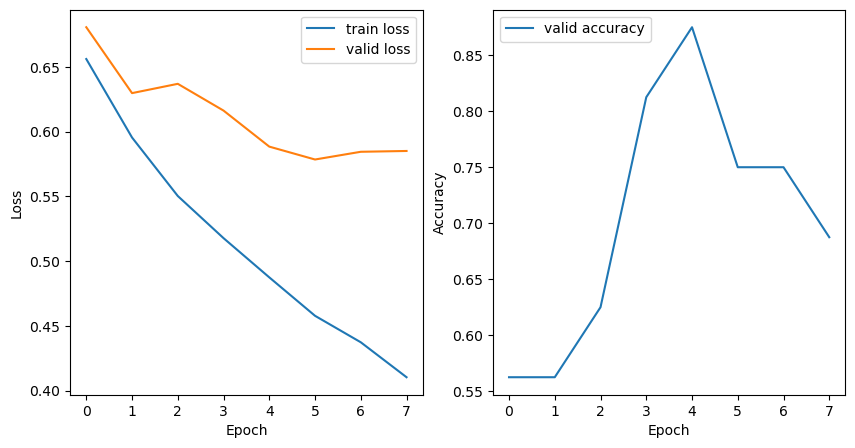

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(range(len(losses_train)),losses_train,label='train loss')
ax[0].plot(range(len(losses_valid)),losses_valid,label='valid loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(range(len(accuracy_valid)),accuracy_valid,label='valid accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
plt.show()

### Check accuracy

In [33]:
scores = []
labels = []

test_dl = DataLoader(ChestData(images_normal_test, images_pneumo_test), batch_size=1, shuffle=False)

net.to(device)

for batch in tqdm(test_dl):
    img, lab = batch
    img = img.to(device)
    labels.append(lab.item())

    with torch.no_grad():
        scores.append(net(img).squeeze(-1).item())

scores = np.array(scores)
labels = np.array(labels, dtype=int)

  0%|          | 0/624 [00:00<?, ?it/s]

In [34]:
preds = (scores > 0.5).astype(int)
accuracy = np.mean(preds == labels)
print(f'Test accuracy: {accuracy*100:.1f}%')

Test accuracy: 74.2%


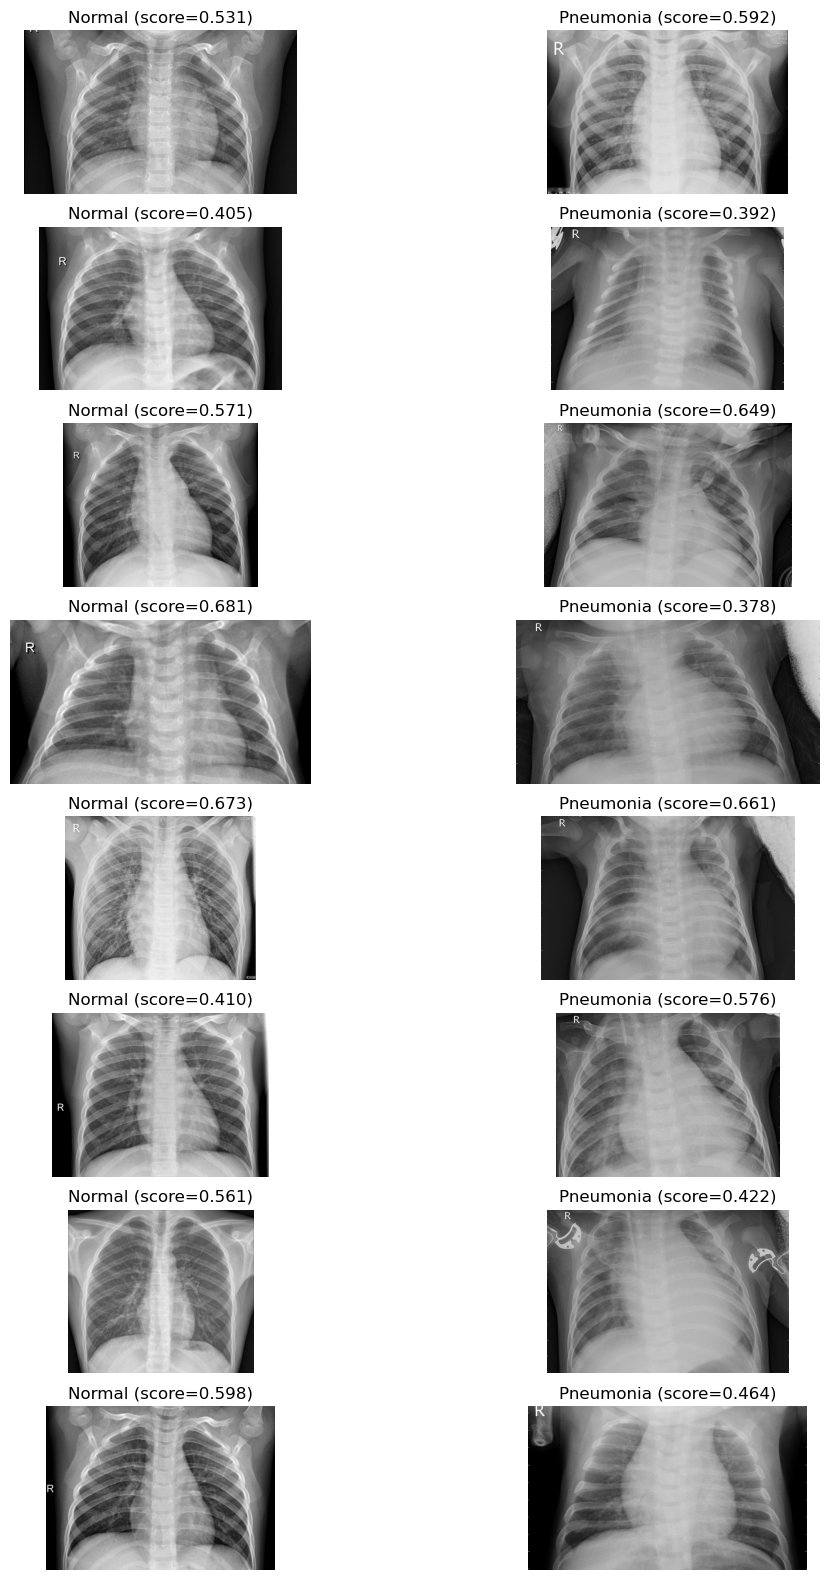

In [35]:
fig, axes = plt.subplots(8, 2, figsize=(12, 20))

for i in range(8):
    axes[i,0].imshow(plt.imread(images_normal_test[i]), cmap='gray')
    axes[i,0].set_title(f'Normal (score={scores[i]:.3f})')
    axes[i,0].set_axis_off()
    axes[i,1].imshow(plt.imread(images_pneumo_test[i]), cmap='gray')
    axes[i,1].set_title(f'Pneumonia (score={scores[i+8]:.3f})')
    axes[i,1].set_axis_off()

plt.show()